In [21]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

In [22]:
station=["01_Rulo",
        "02_St_Joseph",
        "03_Kansas_City",
        "04_Waverly",
        "05_Boonville",
        "06_Hermann",
        "07_St_Charles",
        "08_Grafton",
        "09_ST_Louis",
        "10_Chester"]
USGS_id=["01_Rulo_06813500.csv",
        "02_St_Joseph_06818000.csv",
        "03_Kansas_City_06893000.csv",
        "04_Waverly_06895500.csv",
        "05_Boonville_06909000.csv",
        "06_Hermann_06934500.csv",
        "07_St_Charles_06935965.csv",
        "08_Grafton_05587450.csv",
        "09_ST_Louis_07010000.csv",
        "10_Chester_07020500.csv"]
         
i=9

In [23]:
base = Path(f"/media/12TB/Sujan/NWM/Csv/{station[i]}/All")

df_USGS = pd.read_csv(f"/media/12TB/Sujan/NWM/USGS_data/{USGS_id[i]}",
                      parse_dates=["timestamp"]).set_index("timestamp")

# df_USGS["discharge_cumecs"] = df_USGS["discharge_cfs"] / 35.3147

In [24]:
def find_GH_with_tolerance(
    df_nwm,
    df_usgs,
    day_skip=7,
    day_bracket=7,
    q_tolerance=1.0,
    nwm_col="streamflow",
    usgs_q_col="discharge_cumecs",
    usgs_h_col="stage_ft",
):
    """
    For each NWM time t (after day_skip), search USGS data within [t - day_bracket, t + day_bracket].
    Take the mean of all USGS stages whose discharge lies within ±q_tolerance of the NWM discharge.
    If none match, return NaN. No interpolation.

    Parameters
    ----------
    df_nwm : DataFrame with DatetimeIndex and column nwm_col (default 'streamflow')
    df_usgs : DataFrame with DatetimeIndex and columns usgs_q_col ('discharge_cumecs'),
              usgs_h_col ('stage_ft')
    day_skip : days to skip from the start of df_nwm before processing
    day_bracket : half-window in days around each NWM time
    q_tolerance : discharge tolerance (same units as df_usgs[usgs_q_col])
    nwm_col, usgs_q_col, usgs_h_col : column names for flexibility
    """
    if not isinstance(df_nwm.index, pd.DatetimeIndex):
        raise TypeError("df_nwm must have a DatetimeIndex")
    if not isinstance(df_usgs.index, pd.DatetimeIndex):
        raise TypeError("df_usgs must have a DatetimeIndex")
    for col in [nwm_col]:
        if col not in df_nwm.columns:
            raise KeyError(f"df_nwm needs '{nwm_col}' column")
    for col in [usgs_q_col, usgs_h_col]:
        if col not in df_usgs.columns:
            raise KeyError(f"df_usgs needs '{usgs_q_col}' and '{usgs_h_col}' columns")

    # Keep needed cols and drop NaNs on USGS side
    nwm = df_nwm[[nwm_col]].copy()
    usgs = df_usgs[[usgs_q_col, usgs_h_col]].dropna().copy()

    # Sort by time for fast time-slicing
    nwm.sort_index(inplace=True)
    usgs.sort_index(inplace=True)

    # Apply day_skip
    start_time = nwm.index.min() + pd.Timedelta(days=day_skip)
    nwm_use = nwm.loc[nwm.index >= start_time].copy()

    out_records = []
    halfwin = pd.Timedelta(days=day_bracket)

    for t, row in nwm_use.iterrows():
        q = row[nwm_col]
        if pd.isna(q):
            out_records.append((t, np.nan))
            continue

        # Time window
        us = usgs.loc[t - halfwin : t + halfwin]
        if us.empty:
            out_records.append((t, np.nan))
            continue

        # Discharge band ± q_tolerance
        band = us[(us[usgs_q_col] >= q - q_tolerance) & (us[usgs_q_col] <= q + q_tolerance)]
        if band.empty:
            out_records.append((t, np.nan))
            continue

        gh_mean = float(band[usgs_h_col].mean())
        out_records.append((t, gh_mean))

    result = nwm.copy()
    gh_series = pd.DataFrame(out_records, columns=["time", "Computed_GH_m"]).set_index("time")
    result = result.join(gh_series, how="left")
    return result

def run_one(file_path, df_usgs, code,
            day_skip=0, day_bracket=10, q_tolerance=5.0):
    df_nwm = pd.read_csv(file_path, parse_dates=["time"]).set_index("time")
    out = find_GH_with_tolerance(
        df_nwm, df_usgs,
        day_skip=day_skip,
        day_bracket=day_bracket,
        q_tolerance=q_tolerance,
        nwm_col="streamflow",
        usgs_q_col="discharge_cumecs",
        usgs_h_col="stage_m"
    )

    fill = out["Computed_GH_m"].notna().mean()
    print(f"{code}: filled {fill:.1%}  "
          f"window=±{day_bracket}d, tol={q_tolerance})_")
    return out["Computed_GH_m"].rename(code)

In [25]:
day_bracket = 90  # days on either side of NWM time
day_skip = 30
q_tolerance = 5.0

wide = None
for h in range(6, 721, 6):  # 006..720
    code = f"{h:03d}"
    f = base / f"timeseries_{code}.csv"
    if not f.exists(): 
        continue
    s = run_one(f, df_USGS, code, day_skip, day_bracket, q_tolerance)
    if wide is None:
        wide = pd.DataFrame(index=s.index)
    wide = wide.join(s, how="outer")

# If nothing loaded, bail early
if wide is None:
    raise RuntimeError("No timeseries_* files were found or produced output.")

wide.sort_index(inplace=True)

# 2) Bring USGS stage onto the NWM union index via nearest-time match
# Using merge_asof for robust nearest alignment (set a tolerance you trust)
usgs_stage = (
    pd.merge_asof(
        left=wide.reset_index().rename(columns={"index":"time"}).sort_values("time"),
        right=df_USGS[["stage_m"]].reset_index().rename(columns={"timestamp":"time"}).sort_values("time"),
        on="time", direction="nearest", tolerance=pd.Timedelta("3H")  # adjust tolerance as needed
    )
    .set_index("time")["stage_m"]
    .rename("stage_m_USGS_nearest")
)

# 3) Combine
merged_all = wide.join(usgs_stage, how="left")

merged_all.to_csv(f"/media/12TB/Sujan/NWM/Codes/LRF_RC/NWM_Q_to_GH/{station[i]}_q_tolerance_{q_tolerance}_day_bracket_{day_bracket}.csv")

006: filled 42.1%  window=±90d, tol=5.0)_
012: filled 42.0%  window=±90d, tol=5.0)_
018: filled 42.3%  window=±90d, tol=5.0)_
024: filled 41.6%  window=±90d, tol=5.0)_
030: filled 42.1%  window=±90d, tol=5.0)_
036: filled 40.3%  window=±90d, tol=5.0)_
042: filled 40.9%  window=±90d, tol=5.0)_
048: filled 39.9%  window=±90d, tol=5.0)_
054: filled 38.4%  window=±90d, tol=5.0)_
060: filled 37.7%  window=±90d, tol=5.0)_
066: filled 37.1%  window=±90d, tol=5.0)_
072: filled 36.3%  window=±90d, tol=5.0)_
078: filled 35.9%  window=±90d, tol=5.0)_
084: filled 36.1%  window=±90d, tol=5.0)_
090: filled 37.1%  window=±90d, tol=5.0)_
096: filled 38.6%  window=±90d, tol=5.0)_
102: filled 38.4%  window=±90d, tol=5.0)_
108: filled 40.0%  window=±90d, tol=5.0)_
114: filled 39.4%  window=±90d, tol=5.0)_
120: filled 38.8%  window=±90d, tol=5.0)_
126: filled 38.6%  window=±90d, tol=5.0)_
132: filled 38.9%  window=±90d, tol=5.0)_
138: filled 39.3%  window=±90d, tol=5.0)_
144: filled 39.3%  window=±90d, to

/tmp/ipykernel_372496/3434422489.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  on="time", direction="nearest", tolerance=pd.Timedelta("3H")  # adjust tolerance as needed


In [26]:
merged_all

,006,012,018,024,030,036,042,048,054,060,...,672,678,684,690,696,702,708,714,720,stage_m_USGS_nearest
time,,,,,,,,,,,,,,,,,,,,,
2018-09-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.952
2018-09-17 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.967
2018-09-17 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.952
2018-09-17 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.925
2018-09-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 00:00:00,NaN,1.047429,1.010762,0.988359,0.978854,0.992909,1.073804,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.073804,0.985706,1.119791,1.549678,NaN,1.503
2024-12-30 06:00:00,NaN,1.120512,1.100812,1.066347,1.033763,1.038607,NaN,NaN,1.991829,2.419853,...,NaN,NaN,NaN,NaN,NaN,1.069186,0.975690,1.105429,NaN,1.515
2024-12-30 12:00:00,1.336705,NaN,NaN,NaN,1.121203,1.081898,1.191386,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.066347,0.969826,1.095629,1.527


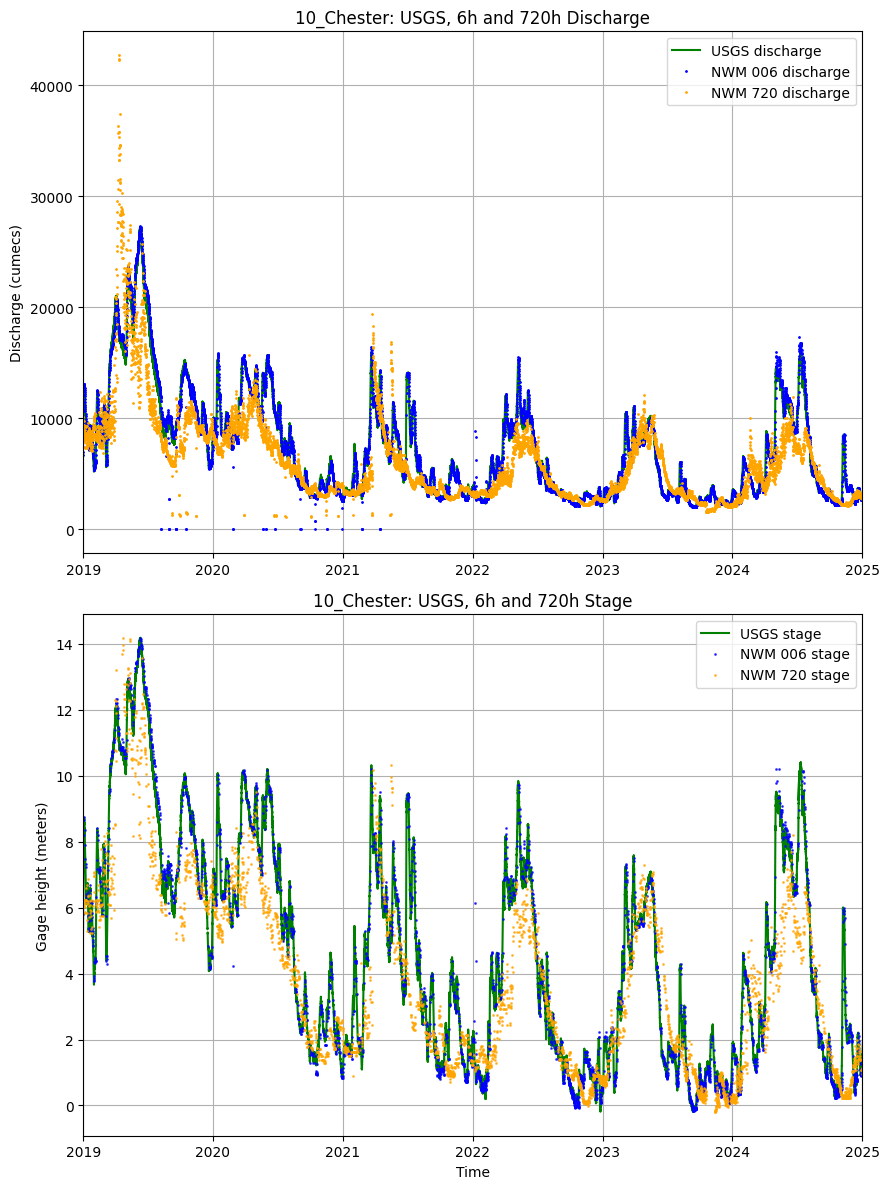

In [27]:
hrs1="006"
hrs2="720"
t0 = "2019-01-01"
t1 = "2025-01-01"

df_hrs1_NWM= pd.read_csv(f"/media/12TB/Sujan/NWM/Csv/{station[i]}/All/timeseries_{hrs1}.csv", parse_dates=["time"]).set_index("time")
df_hrs2_NWM= pd.read_csv(f"/media/12TB/Sujan/NWM/Csv/{station[i]}/All/timeseries_{hrs2}.csv", parse_dates=["time"]).set_index("time")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 12))
ax1.plot(df_USGS.index, df_USGS["discharge_cumecs"],  label="USGS discharge", color='green')
ax1.plot(df_hrs1_NWM.index, df_hrs1_NWM["streamflow"],"o", label=f"NWM {hrs1} discharge", color='blue', markersize=1)
ax1.plot(df_hrs2_NWM.index, df_hrs2_NWM["streamflow"],"o", label=f"NWM {hrs2} discharge", color='orange', markersize=1)

ax2.plot(df_USGS.index, df_USGS["stage_m"],  label="USGS stage", color='green' )
ax2.plot(merged_all.index, merged_all.get(hrs1), "o", label=f"NWM {hrs1} stage", alpha=0.7, color='blue', markersize=1  )
ax2.plot(merged_all.index, merged_all.get(hrs2),"o", label=f"NWM {hrs2} stage", alpha=0.7, color='orange', markersize=1)
ax1.set_ylabel("Discharge (cumecs)")
ax1.set_title(f"{station[i]}: USGS, 6h and 720h Discharge")
ax1.legend()
ax1.grid()  
ax1.set_xlim(pd.to_datetime(t0), pd.to_datetime(t1))

ax2.set_xlabel("Time")
ax2.set_xlim(pd.to_datetime(t0), pd.to_datetime(t1))
ax2.set_ylabel("Gage height (meters)")
ax2.set_title(f"{station[i]}: USGS, 6h and 720h Stage")
ax2.legend()
ax2.grid()
plt.tight_layout()
fig.savefig(f"/media/12TB/Sujan/NWM/Codes/LRF_RC/NWM_Q_to_GH/{station[i]}_q_tolerance_{q_tolerance}_day_bracket_{day_bracket}.png", dpi=300)


